# Data Science 2
## Numerical analysis - Optimization

The following material is largely covered in Chapter 10 - *Introduction to Optimization* of the book *Numerical methods in engineering with Python 3* by Jaan Kiusalaas (see BlackBoard).

### Introduction

[Optimization](https://en.wikipedia.org/wiki/Mathematical_optimization) is the term often used for minimizing or maximizing a function. It is sufficient to consider the problem of minimization only; maximization of $f(x)$ is achieved by simply minimizing $-f(x)$.

Optimization is a large topic with many books dedicated to it. The best we can do in limited space is to introduce a few basic methods that are good enough for problems that are reasonably well behaved and do not involve too many variables. By omitting the more sophisticated methods, we may actually not miss all that much. All optimization algorithms are unreliable to a degree - any one may work on one problem and fail on another. As a rule of thumb, by going up in sophistication we gain computational efficiency, but not necessarily reliability.

The algorithms for minimization are iterative procedures that require starting values of the variable $x$. If $f(x)$ has several local minima, the initial choice of $x$ determines which of these will be computed. There is no guaranteed way of finding the global optimal point. One suggested procedure is to make several computer runs using different starting points and pick the best result.

The majority of available methods are designed for unconstrained optimization, where no restrictions are placed on the variables. In these problems the minima, if they exist, are stationary points (points where the derivative of $f(x)$ vanishes). There are special algorithms for constrained optimization, where certain conditions are imposed on the allowed values of $x$, but they are not easily accessible because of their complexity and specialization. One way to tackle a problem with constraints is to use an unconstrained optimization algorithm, but to modify the function so that any violation of constrains is heavily penalized.

### Minimum bracketing

Before starting any minimum-searching procedure, it is advisable to bracket the minimum; otherwise one cannot be sure that there exists any solution to the given optimization problem. This is comparable to incremental search in root finding to bracket a root.

A minimum is bracketed using three points $(a, b, c)$, if $a < b < c$ and $f(b)$ is less than both $f(a)$ and $f(c)$. If this condition holds and the function $f(x)$ is continuous in the interval $(a, c)$, then $f(x)$ must have a minimum for some $x$, $a < x < c$.

A very simple minimum bracketing procedure therefore starts by subdividing a given interval into $n$ smaller intervals, leading to points $x_0$ to $x_n$ where the function is evaluated, and then searches for a sequence of three consecutive points for which the aforementioned condition holds. Like for the `rootsearch()` method, this method is not guaranteed to find *all* local minima. However, when it reports an interval, that is guaranteed to contain a minimum somewhere.

More sophisticated methods exist that change the size of the intervals dynamically, or that try to guess the position of a minimum based on curvature, for instance. However, we will not discuss these here since the increase in complexity is often not worth the gain in performance.

**Exercise 1**

Complete the below generator function `minimumsearch` to implement the bracketing method described above. The user supplies a function $f$, an interval $(a, b)$, and (optionally) a number of steps. The function should return the low and high endpoints of each interval that brackets a minimum that it can find.

Note: Again assume that the evaluation of `f` is computationally intensive, so minimize the number of function evaluations (i.e. do not evaluate the function twice for the same argument value)!

In [1]:
def minimumsearch(f, a, b, steps):
    """lo, hi = minimumsearch(f, a, b, steps).
    Searches the interval (a,b) in a number of steps for
    the bounds (lo,hi) of the minima of f(x).
    """
    if steps < 2:
        steps = 2
    h = (b- a) / steps
    lo = a
    md = a + h 
    f_lo = f(lo)
    f_md = f(md)
    for i in range(2, steps +1):
        hi = a + h * i
        f_hi = f(hi)
        
        if f_md < f_lo and f_md <= f_hi:
            yield lo, hi
            
        lo, f_lo = md, f_md    
        md, f_md= hi, f_hi
        

We apply the method to find the minimum of the function $f(x) = x \ln|x|$ (with derivative $f'(x) = 1+\ln|x|$) in an interval $(a, b) = (-1, +1)$. The exact solution equals $x_\min = \frac{1}{e} \approx 0.3678794411714423216$.

0.3400000000000001 < 0.36787944117144233 < 0.3800000000000001


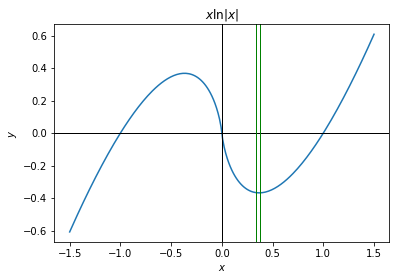

In [2]:
# Example: Minimize x*ln|x|
from math import log
func = lambda x: x * log(abs(x)) if x != 0.0 else 0.0     # the function, for now
dfunc = lambda x: 1.0 + log(abs(x))                       # the derivative, for later
solution = 0.3678794411714423216

for lo, hi in minimumsearch(func, -1.0, 1.0, 100):
    print(lo, '<', solution, '<', hi)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

xs = np.linspace(-1.5, 1.5, 200)
ys = xs * np.log(np.abs(xs))

plt.plot(xs, ys, '-')
plt.axhline(y=0.0, linewidth=1, color='k'); plt.axvline(x=0.0, linewidth=1, color='k')
plt.axvline(x=lo, linewidth=1, color='g'); plt.axvline(x=hi, linewidth=1, color='g')
plt.title('$x\ln|x|$'); plt.xlabel('$x$'); plt.ylabel('$y$'); plt.show()

### Golden Section Search

The [golden section search](https://en.wikipedia.org/wiki/Golden-section_search) is the counterpart of bisection used in finding roots of equations. It does not require the derivative of $f(x)$ to be provided, but it does make use of bracketing.

Suppose that at least one of the minima of $f(x)$ has been bracketed in the interval $(a, b)$ of length $h$. To telescope the interval, we evaluate the function at two intermediate points $x_1 = a + c \cdot h$ and $x_2 = b - c \cdot h$. The constant $c$ is to be chosen down below, but can be taken $c=\frac{1}{3}$ for now in order to divide the interval into three equal parts.

Next, we evaluate the function at the points $x_1$ and $x_2$. If $f(x_1) > f(x_2)$, a minimum can be found in the smaller interval $(x_1, b)$; otherwise it is located in $(a, x_2)$. Thus, we decrease the size of the interval by a factor $1-c$. To carry out the next telescoping operation we evaluate the function at two new intermediate points and repeat the process.

It turns out that one of the intermediate points can be re-used in the subsequent iterations. This halves the number of function evaluations, which is attractive if the function $f(x)$ is expensive to compute. This situation is illustrated below.

<div></div>

The initial interval $(a, b)$ is shown on top; the next interval $(a', b')$ is shown immediately below (here, we assumed $f(x_1) < f(x_2)$, but a mirrored situation occurs for the other case). We see that the new value $x_2'$ coincides with the old value $x_1$. The idea only works for a particular choice of the factor $c$. It turns out that the interval needs to be subdivided according to the [golden ratio](https://en.wikipedia.org/wiki/Golden_ratio) $\phi = \frac{\sqrt{5}-1}{2}$ = 0.618034.. More precisely, $c = 1-\phi = \phi^2 = \frac{3-\sqrt{5}}{2}$ = 0.381966..

Note that each telescoping decreases the interval containing the minimum by the factor $\phi$, which is not as good as the factor $\frac{1}{2}$ in bisection. However, the golden search method achieves this reduction with *one function evaluation*, whereas two evaluations would be needed in bisection.

**Exercise 2**

Write the below function `golden_search` that finds a minimum for a function `f`, starting from initial brackets `a` and `b` that contain a minimum. Stop when the size of the interval is smaller than some tolerance `tol`.

In [3]:
(3.0 - np.sqrt(5.0)) / 2.0

0.3819660112501051

In [4]:
from math import sqrt
# Slower than bisection
def golden_search(f, a, b, tol=1e-8):
    """minimum = golden_search(f, a, b, tol=...).
    Finds a minimum of the function f using golden
    section search, starting from bracketing values
    a and b and ending when |b-a| < tol.
    """
    factor = (3.0 - sqrt(5.0)) / 2.0

    x1 = a + factor * (b - a)
    x2 = b - factor * (b - a)
    f1 = f(x1)
    f2 = f(x2)
    while abs(b-a) > tol:
        if f1 < f2:
            b = x2
            x2 = x1
            f2 = f1
            x1 = a + factor * (b - a)
            f1 = f(x1)
        else:
            a = x1
            x1 = x2
            f1 = f2
            x2 =  b - factor * (b - a)
            f2 = f(x2)
            
            
    return (a + b) / 2.0

We apply the method to find the minimum of the function $f(x) = x \ln|x|$ inside the bracketing interval that was determined previously.

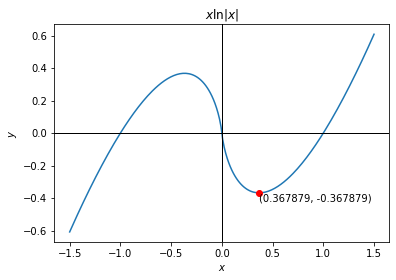

In [5]:
# Example: Minimize x*ln|x|
xmin = golden_search(func, lo, hi)
ymin = func(xmin)

plt.plot(xs, ys, '-')
plt.plot(xmin, ymin, 'or')
plt.text(xmin, ymin, f'({xmin:.6f}, {ymin:.6f})', verticalalignment='top')
plt.axhline(y=0.0, linewidth=1, color='k'); plt.axvline(x=0.0, linewidth=1, color='k')
plt.title('$x\ln|x|$'); plt.xlabel('$x$'); plt.ylabel('$y$'); plt.show()

### Gradient descent

[Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) is a first-order iterative optimization algorithm for finding a local minimum of a differentiable function. To find a local minimum of a function using gradient descent, we take steps proportional to the negative of the gradient (or approximate gradient) of the function at the current point. (If we take steps proportional to the positive of the gradient instead, we approach a local maximum of that function; the procedure is then known as *gradient ascent*). Gradient descent was originally proposed by Cauchy in 1847.

The intuition behind gradient descent is simple: if the derivative $f'(x)$ is positive, then the function increases; so, in order to arrive at a minimum, $x$ would need to be decreased. Conversely, if $f'(x) < 0$, then the function decreases, and $x$ needs to be increased. This behaviour can be summarized by an update rule

$$
x \leftarrow x - \gamma \cdot f'(x)
$$

This formula also has the advantage that when the method approaches a solution, the derivative becomes small, and therefore also the updates become smaller. However, it requires the derivative $f'(x)$ to be known, or to be calculable (e.g. using numeric differentiation).

The parameter $\gamma$ is called the *learning rate* and determines the size of the adjustments that are made. The magnitude of this parameter is critical: if its value is too low, then the solution converges only very slowly, which may make the computation intractable; if its value is too high, then the solution may overshoot and not converge at all.

Gradient descent is an important algorithm that is used a lot in deep learning, for instance. There are many extensions to this algorithm. For example, there are methods that adaptively choose a correct learning rate, that avoid getting stuck in local minima, or that can handle complications that arise when functions depend on multiple variables $x_1, x_2, \ldots$. We will only consider the most basic case here.

**Exercise 3**

Complete the below function `gradient_search` that finds a minimum for an (unspecified) function `f` for which the derivative `df` is provided using gradient descent, starting from some initial value `x`. Stop when the magnitude of the derivative $|f'(x)|$ is smaller than some tolerance `tol`.

In [6]:
def gradient_search(df, x, gamma=0.1, tol=1e-8):
    """minimum = gradient_search(df, x, gamma=..., tol=...).
    Finds a minimum of the function f with derivative df
    using gradient descent with learning rate gamma,
    starting from x and ending when |df| < tol.
    """
    dof = df(x)
    new_x = x - gamma*dof
    
    while abs(dof) > tol:
        x = new_x
        dof = df(x)
        new_x = x - gamma*dof
    return new_x

### Gradient search without knowing the derivative

In [7]:
def central_derivative(f, x, h=1e-8):
    """df = central_derivative(f, x, h).
    Calculates the central difference approximation of the
    function f(x).
    """
    df = (f(x + h) - f(x - h)) / (2 * h)
    return df

In [8]:
def gradient_search_der(f, x, gamma=0.1, tol=1e-8):
    """minimum = gradient_search(df, x, gamma=..., tol=...).
    Finds a minimum of the function f with derivative df
    using gradient descent with learning rate gamma,
    starting from x and ending when |df| < tol.
    """
    df = central_derivative(f, x)
    new_x = x - gamma*df
    
    while abs(df) > tol:
        x = new_x
        df = central_derivative(f, x)
        new_x = x - gamma*df
#         print(df)
    return new_x

We apply this algorithm to the same function as above, starting in the middle of the interval that brackes the root. Investigate what happens for different learning rates $\gamma$.

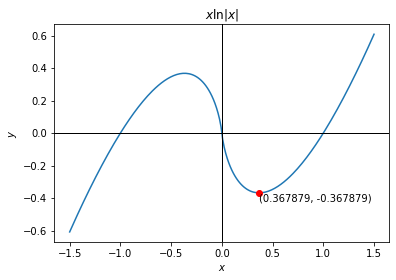

In [9]:
# Example: Minimize x*ln|x|
xmin = gradient_search(dfunc, (lo + hi) / 2.0, 1e-4)
ymin = func(xmin)

plt.plot(xs, ys, '-')
plt.plot(xmin, ymin, 'or')
plt.text(xmin, ymin, f'({xmin:.6f}, {ymin:.6f})', verticalalignment='top')
plt.axhline(y=0.0, linewidth=1, color='k'); plt.axvline(x=0.0, linewidth=1, color='k')
plt.title('$x\ln|x|$'); plt.xlabel('$x$'); plt.ylabel('$y$'); plt.show()

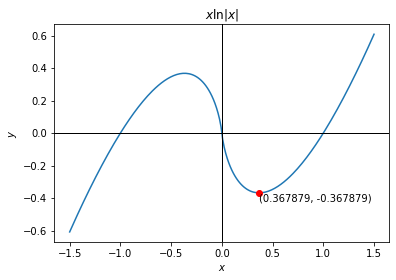

In [10]:
# With gradient_search_der function !!!!

# Example: Minimize x*ln|x|
xmin = gradient_search_der(func, (lo + hi) / 2.0, 1e-4)
ymin = func(xmin)

plt.plot(xs, ys, '-')
plt.plot(xmin, ymin, 'or')
plt.text(xmin, ymin, f'({xmin:.6f}, {ymin:.6f})', verticalalignment='top')
plt.axhline(y=0.0, linewidth=1, color='k'); plt.axvline(x=0.0, linewidth=1, color='k')
plt.title('$x\ln|x|$'); plt.xlabel('$x$'); plt.ylabel('$y$'); plt.show()

### Exercises

**Exercise 4**

The function $g(x) = 2x^2 - 3x^4$ has one local minimum at $x = 0$. Calling the function `golden_search(func, a=-2.0, b=+2.0)` reports a minimum near $x = -2$ or $x = +2$, close to the edge of the bracketing interval, despite that the minimum is smack in the middle of the interval.

Explain why this happens, and modify the function parameters such that they are able to identify the minimum.

In [11]:
from scipy.optimize import golden

def g(x):
    return 2*x**2 - 3*x**4
x = np.linspace(-2, 2, 501)

In [12]:
xmin = golden_search(g, -0.5, 0.5, tol = 1e-20)
ymin = g(xmin)

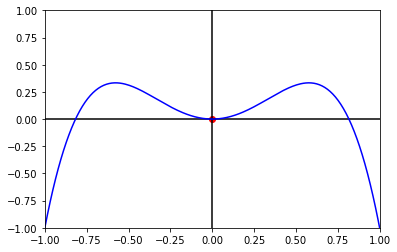

In [13]:

plt.axhline(0, color = 'k')
plt.axvline(0, color = 'k')
plt.axis([-1, 1, -1, 1])
plt.plot(x , g(x), '-b')
plt.scatter(xmin, ymin, color = 'red')
plt.show()

In [14]:
golden_search(g, -0.5, 0.5, tol = 1e-20)

-8.017498489832915e-22

**Exercise 5**

Determine *all* (local and global) <u>max</u>ima of the function

$$
f(x) = \sin(x) - \frac{x^2}{2\pi}
$$

using your own golden section search as well as the [golden()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.golden.html) function from the `scipy.optimize` submodule.

In [15]:
from math import sqrt
# Slower than bisection
def max_golden_search(f, a, b, tol=1e-8):
    """minimum = golden_search(f, a, b, tol=...).
    Finds a minimum of the function f using golden
    section search, starting from bracketing values
    a and b and ending when |b-a| < tol.
    """
    
    factor = (3.0 - sqrt(5.0)) / 2.0

    x1 = a + factor * (b - a)
    x2 = b - factor * (b - a)
    f1 = f(x1)
    f2 = f(x2)
    while abs(b-a) > tol:
        if f1 > f2: # if operant '>' algo finds maxima else finds minimum
            b = x2
            x2 = x1
            f2 = f1
            x1 = a + factor * (b - a)
            f1 = f(x1)
        else:
            a = x1
            x1 = x2
            f1 = f2
            x2 =  b - factor * (b - a)
            f2 = f(x2)
            
            
    return (a + b) / 2.0

In [16]:
def maximumsearch(f, a, b, steps):
    """lo, hi = minimumsearch(f, a, b, steps).
    Searches the interval (a,b) in a number of steps for
    the bounds (lo,hi) of the minima of f(x).
    """
    if steps < 2:
        steps = 2
    h = (b- a) / steps
    lo = a
    md = a + h 
    f_lo = f(lo)
    f_md = f(md)
    for i in range(2, steps +1):
        hi = a + h * i
        f_hi = f(hi)
        
        if f_md > f_lo and f_md >= f_hi:  # if operant '>' algo finds maxima else finds minimum
            yield lo, hi
            
        lo, f_lo = md, f_md    
        md, f_md= hi, f_hi
        

In [19]:
def f(x): 
    return np.sin(x) - (x**2/ (2* np.pi))
x = np.linspace(-7, 7, 501)    

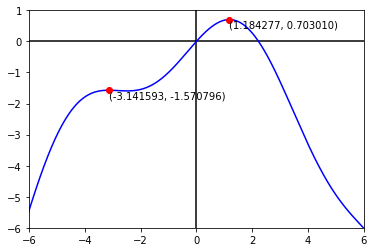

In [20]:
plt.axhline(0, color = 'k')
plt.axvline(0, color = 'k')

plt.plot(x , f(x), '-b')

plt.axis([-6, 6, -6, 1])
for (lo, hi) in list(maximumsearch(f, -7, 7, 1000)):
    xmax = max_golden_search(f,lo, hi, 1e-8)
    ymax = f(xmax)
    plt.plot(xmax, ymax, 'or')
    plt.text(xmax, ymax, f'({xmax:.6f}, {ymax:.6f})', verticalalignment='top')

plt.show()   

**Exercise 6**

Out of golden section search and gradient descent, only one method is appropriate to determine the global minimum of the function $f(x) = |x|$ to arbitrary precision. Apply this method to find the minimum. Why does the other method not converge to a solution?

In [21]:
def z(x):
    return np.abs(x)
x= np.linspace(-2, 2, 501)

Gradient decent checks the slope (the higher the slope more bigger steps downwards it should go) but the slope in this function is always the same so it doesn't make sense 

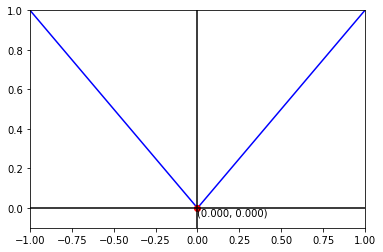

In [22]:
plt.plot(x , z(x), '-b')


for (lo, hi) in list(minimumsearch(z, -1, 1, 1000)):
    xmin = golden_search(z,lo, hi, 1e-30)
    ymin = z(xmin)
    plt.plot(xmin, ymin, 'or')
    plt.text(xmin, ymin, f'({xmin:.3f}, {ymin:.3f})', verticalalignment='top')


plt.axhline(0, color = 'k')
plt.axvline(0, color = 'k')
plt.axis([-1, 1, -0.1, 1])
plt.show()

**Exercise 7**

Use the code below to generate and plot a data sample containing a total of $N = 100$ data points with $y$- and $t$-values.

```python
t = np.linspace(0, 10, 100)
y = np.sin(t) + np.random.randn(100) / 10
plt.plot(t, y, 'x'); plt.axhline(y=0.0, linewidth=1, color='k'); plt.show()
```

We wish to fit these data with the oscillating function

$$
y_f(t) = \sin(2 \pi f \cdot t)
$$

but we do not know the correct frequency $f$. One approach is to use *non-linear regression*, in which case we try to minimize the mean-squared-error

$$
\text{MSE}(f) = \frac{1}{N} \sum_i^N \left( y_i - y_f(t_i) \right) ^2
$$

such that

$$
\frac{\text{d}}{\text{d}f} \text{MSE}(f) = \frac{1}{N} \sum_i^N -4 \pi t_i \cdot \left( y_i - \sin(2 \pi f t_i) \right) \cdot \cos(2 \pi f t_i)
$$

Use gradient descent to find the optimal value for $f$ that minimizes the MSE. Add the fitted sinusoid to the plot. Note: based on the plot, an initial guess between 0.1 and 0.2 seems reasonable.

A similar procedure may be used to e.g. determine a heartbeat frequency from blood pressure data, etc.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
t = np.linspace(0, 10, 100)
y = np.sin(t) + np.random.randn(100) / 10


In [24]:
def y_f(t, f):
    return np.sin(f*2* np.pi*t)

In [25]:
##### Use this func to plot the MSE JUST FOR PLOTTING
def MSE_PLOT(f):
    y_1 = []
    for fi in f:
        y_1.append((np.sum( (y - y_f(t, fi))**2 )) / 100)
    return y_1
f = np.linspace(0.1,0.2, 100)

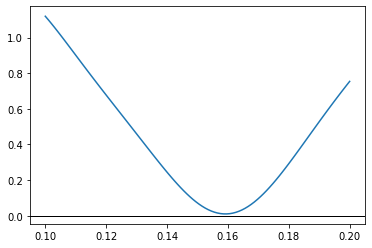

In [26]:
plt.plot(f, MSE_PLOT(f))
plt.axhline(y=0.0, linewidth=1, color='k')
# plt.axis([0.12, 0.17, -0.001, 0.1])
# plt.axvline(x=0.0, linewidth=1, color='k')
plt.show()

In [27]:
def MSE(f):
    return np.sum( (y - y_f(t, f))**2 ) / 100

f = np.linspace(0.1,0.2, 100)

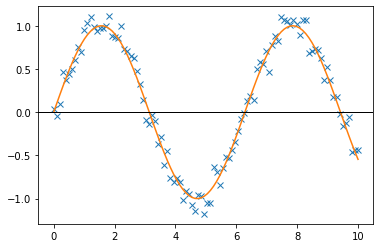

f: 0.15918444977896343


In [28]:
for lo, hi in list(minimumsearch(MSE, 0.1, 0.2, 10)):
    plt.plot(t, y, 'x')
    plt.plot(t, y_f(t, gradient_search_der(MSE,(lo+hi)/2,0.00001,  1e-8) ))
    plt.axhline(y=0.0, linewidth=1, color='k')
    plt.show()
    print('f:',gradient_search_der(MSE,(lo+hi)/2,0.00001,  1e-8))

    

***